In [1]:
import sys
sys.path.append('SheetIdentification')
sys.path.append('SheetIdentification/sheet_id')
sys.path.append('SheetIdentification/sheet_id/models')
sys.path.append('SheetIdentification/sheet_id/utils')
from DWD import DWD
from dwd_utils import generateFullpagePrediction, inferBoundingBoxes
from base_utils import visualizeBoundingBoxes
import numpy as np
import cv2
import matplotlib.pyplot as plt

Using TensorFlow backend.
/home/dbashir/anaconda2/envs/py36/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)


In [2]:
import numpy as np
from scipy.spatial.distance import cdist
from scipy import ndimage
from scipy import signal
from scipy.stats import linregress
from scipy.signal import convolve2d, gaussian, argrelextrema
from scipy.interpolate import interp1d
from sklearn.preprocessing import normalize
from skimage.transform import rotate
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import pickle as cPickle
import librosa
import glob
import re
import sys
import os
import mido
from mido import MidiFile
import cv2
from PIL import Image

In [51]:
model = DWD(input_shape=(500,500,1), n_classes=124)
model.load_weights('dwd-finetune-100000.h5')

In [3]:
def importImage(pngfile):
    img = ndimage.imread(pngfile, flatten=True)
    img = 1 - img/255.0 # make white -> 0, black -> 1
    return img

In [4]:
def showImage(X, sz = (12,12)):
    plt.figure(figsize=sz)
    plt.imshow(1-X, cmap='gray')

In [5]:
def rotateToHorizontal(img, lb=-.5, ub=.5, incr=.02, topN=40):
    bestscore = -np.inf
    bestTheta = 0
    for theta in np.arange(lb, ub, incr):
        imgRot = rotate(img,theta)
        rsums = np.sum(imgRot, axis=1)
        rsums_sorted = sorted(rsums)[::-1]
        curscore = np.sum(rsums_sorted[0:topN])
        if curscore > bestscore:
            bestscore = curscore
            bestTheta = theta
    result = rotate(img,bestTheta)
    return result, bestTheta

In [6]:
def getBoundingBox(img, thresh=.01, buff=0.05, debug=False):
    r = img.shape[0]
    c = img.shape[1]
    
    cmeans = np.mean(img, axis=0)
    cmean_thresh = np.max(cmeans) * thresh
    cidxs_above = np.argwhere(cmeans > cmean_thresh)
    col_start = cidxs_above[0][0]
    col_end = cidxs_above[-1][0]
    
    rmeans = np.mean(img, axis=1)
    rmean_thresh = np.max(rmeans) * thresh
    ridxs_above = np.argwhere(rmeans > rmean_thresh)
    row_start = ridxs_above[0][0]
    row_end = ridxs_above[-1][0]
    
    # add buffer to ignore clefs
    bufflen = np.int((col_end - col_start) * buff)
    col_start_adj = col_start + bufflen
    
    if debug:
        print("cmeans:  " + str(cmeans))
        print("cmean thresh: " +  str(cmean_thresh))
        
        print("rmeans: " + str(rmeans))
        print("rmean_thresh: " + str(rmean_thresh))
    
    return (row_start, col_start_adj), col_end - col_start_adj, row_end - row_start

In [7]:
def showImageWithBB(X, loc, w, h, sz=(12,12)):
    fig = plt.figure(figsize=sz)
    plt.imshow(1-X, cmap='gray')
    ax = fig.gca()
    rect = patches.Rectangle((loc[1],loc[0]), w, h, linewidth=1,edgecolor='r',facecolor='none')
    ax.add_patch(rect)
    plt.show()

In [8]:
def getCropped(X, thresh=0.01):
    ll, w, h = getBoundingBox(X, thresh=thresh)
    return X[ll[0]:ll[0]+h,ll[1]:ll[1]+w]

In [9]:
def getStripBoundaries(X, showPlot = False):
    # find staves
    filt = np.vstack((np.ones(21),np.zeros(21),-1*np.ones(21))) # emphasize horizontal lines
    Xfilt = signal.convolve2d(X-np.mean(X), filt, mode='same')
    rsum = np.sum(Xfilt, axis=1)
    rsum_spectra = librosa.core.stft(rsum,n_fft=32,hop_length=1) # look for high frequency oscillations
    spectra_max = np.max(rsum_spectra[4:10,:], axis=0)
    spectra_max_smoothed = np.convolve(spectra_max,np.hanning(15),'same')
    peakidxs = signal.find_peaks_cwt(spectra_max_smoothed, range(15,41,1))
    #assert(len(peakidxs) % 2 == 0)
    
    # determine boundaries
    numStrips = np.int(len(peakidxs))
    boundaries = []
    for i in range(numStrips):
        peak1idx = peakidxs[i]
        if i >= (numStrips - 1):
            break
        peak2idx = peakidxs[i+1]
        midpt = np.int((peak1idx + peak2idx)/2.0)
        boundaries.append(midpt)
    boundaries.insert(0, 0)  # for first strip
    boundaries.append(X.shape[0]-1) # for last strip
    
    # show peak picking results (for debugging)
    if showPlot:
        plt.plot(spectra_max_smoothed)
        for pk in peakidxs:
            plt.axvline(x=pk, color='r', linewidth=1)
            
    return boundaries

In [10]:
def visualizeBoundaries(X, bnds, savefile = None):
    showImage(X)
    for bnd in bnds:
        plt.axhline(y=bnd, color='r', linewidth=1)
    if savefile:
        plt.savefig(savefile)

In [11]:
def getStrips(X, bnds):
    strips = []
    for i in range(len(bnds)-1):
        rstart = bnds[i]
        rend = bnds[i+1] + 1 # include endpoint
        chunk = X[rstart:rend,:]
        strips.append(chunk)
    return strips

In [12]:
def showStrips(strips):
    for strip in strips:
        showImage(strip)

In [13]:
def locateStaffLines(s, delta = 3, debug=False):
    medvals = np.median(s, axis=1)
    if debug:
        print("num medvals: " + str(len(medvals)))
        print("medvals are: " +  str(medvals))
    for i, curVal in enumerate(medvals):
        if i > delta and i < len(medvals)-delta:
            if curVal != np.max(medvals[i-delta:i+delta+1]): # only keep local maxima
                medvals[i] = 0
    idxs_sorted_val = np.argsort(medvals)[::-1]
    idxs_lines = sorted(idxs_sorted_val[0:10]) # going to change from [0:10] to [0:10] skipping by 2
    idxs_lines = idxs_lines[1::2] # we want just 5, so start at the second and skip every other.
    if debug:
        print("sorted idxs val before clip: " + str(idxs_sorted_val))
        print("num sorted idxs: " + str(len(idxs_sorted_val)))
        print("idxs_lines number after clip: " + str(len(idxs_lines)))
        print("idxs_lines: " + str(idxs_lines))
    return np.array(idxs_lines)

In [14]:
def estimateMidiNum2PixelRowMapping(s, lineIdxs):
    x = np.array([4, 2, 0, -2, -4]) # midi nums for staff lines, reformatted to be 0 in the middle, etc.
    m, b, _, _, _ = linregress(x, lineIdxs)
    return (m,b)

In [15]:
def estimatePixelRow (midinum, m, b):
    return np.int(np.round(midinum * m + b))

In [16]:
def estimatePixelRow2MidiNumMapping(s, lineIdxs):
    x = np.array([4, 2, 0, -2, -4]) # midi nums for staff lines
    m, b, _, _, _ = linregress(lineIdxs, x)
    return (m,b)

In [17]:
def getStripBoundariesNonPiano(X, showPlot = False):
    # find staves
    filt = np.vstack((np.ones(21),np.zeros(21),-1*np.ones(21))) # emphasize horizontal lines
    Xfilt = signal.convolve2d(X-np.mean(X), filt, mode='same')
    rsum = np.sum(Xfilt, axis=1)
    rsum_spectra = librosa.core.stft(rsum,n_fft=32,hop_length=1) # look for high frequency oscillations
    spectra_max = np.max(rsum_spectra[4:10,:], axis=0)
    spectra_max_smoothed = np.convolve(spectra_max,np.hanning(15),'same')
    peakidxs = signal.find_peaks_cwt(spectra_max_smoothed, range(15,41,1))
    #assert(len(peakidxs) % 2 == 0)
    
    # determine boundaries
    numStrips = np.int(len(peakidxs)/2) # note the lack of -1 here
    boundaries = []
    for i in range(numStrips):
        peak1idx = peakidxs[2*i]
        peak2idx = peakidxs[2*i+1]
        midpt = np.int((peak1idx + peak2idx)/2.0)
        boundaries.append(midpt)
    boundaries.insert(0, 0)  # for first strip
    boundaries.append(X.shape[0]-1) # for last strip
    
    # show peak picking results (for debugging)
    if showPlot:
        plt.plot(spectra_max_smoothed)
        for pk in peakidxs:
            plt.axvline(x=pk, color='r', linewidth=1)
            
    return boundaries

In [18]:
from matplotlib.collections import PatchCollection
from matplotlib.patches import Rectangle
def visualizeBoundingBoxes(img, boxes, figsize=(20, 20)):
    """
    Visualize bounding boxes on the provided image
    """
    _, ax = plt.subplots(1, 1, figsize=figsize)
    ax.imshow(img, cmap='gray')
    patches = []
    for box in boxes:
        patches.append(Rectangle((box[0], box[1]), box[2]-box[0], box[3]-box[1]))
    pc = PatchCollection(patches, facecolor='None', edgecolor='r')
    ax.add_collection(pc)

In [19]:
def get_lines_bboxes(strip, debug=False):
    lines = locateStaffLines(strip)
    inv_s = (255*(1-strip)).astype(int)
    energy_map, class_map, bbox_map = generateFullpagePrediction(model, inv_s)
    boxes, scores = inferBoundingBoxes(energy_map, class_map, bbox_map, non_max_suppression_factor=0.25)
    if debug:
        print("boxes: " + str(boxes))
        print("energy map: " + str(energy_map))
    return (inv_s,boxes,lines)
    # you'd do smth like (inv_s, boxes, lines = get_lines_bboxes)

In [20]:
def visualize_output(s, inv_s, lines, boxes):
    visualizeBoundingBoxes(inv_s, boxes)
    for line in lines:
        plt.axhline(y=line, color='r', linewidth=1)
    plt.show()
    
    value_array = []
    x_vals = []
    y_vals = []
    notes = []
    notes_w_locations = []
    for box in boxes:
        x1 = box[0]
        x2 = box[2]
        y1 = box[1]
        y2 = box[3]
        x_val = (x1+x2)/2
        y_val = (y1+y2)/2
        value_array.append((x_val, y_val))
        x_vals.append(x_val)
        y_vals.append(y_val)
    counter = 0
    for y_val in y_vals:
        m, b = estimatePixelRow2MidiNumMapping(s, lines[0:5])
        estNote = estimatePixelRow(y_val, m, b)
        notes.append(estNote)
        notes_w_locations.append((estNote, x_vals[counter]))
        counter += 1
    notes_w_locations = sorted(notes_w_locations, key=lambda x: x[1])
    print('note-location pairs: ' + str(notes_w_locations))

In [53]:
def visualize_bboxes(s, inv_s, boxes):
    visualizeBoundingBoxes(inv_s, boxes)
    
    value_array = []
    x_vals = []
    y_vals = []
    notes = []
    notes_w_locations = []
    for box in boxes:
        x1 = box[0]
        x2 = box[2]
        y1 = box[1]
        y2 = box[3]
        x_val = (x1+x2)/2
        y_val = (y1+y2)/2
        value_array.append((x_val, y_val))
        x_vals.append(x_val)
        y_vals.append(y_val)
    counter = 0
    for y_val in y_vals:
        m, b = estimatePixelRow2MidiNumMapping(s, lines[0:5])
        estNote = estimatePixelRow(y_val, m, b)
        notes.append(estNote)
        notes_w_locations.append((estNote, x_vals[counter]))
        counter += 1

First let's convert Kreutzer 8 to PNG.

In [41]:
pic = 'etude_8_300dpi.png'

In [84]:
pdf_file = 'etude_8.pdf'

In [85]:
pngout = 'etude_8_300dpi.png'

In [87]:
import subprocess
subprocess.call(['convert', '-density', '300', pdf_file, pngout])

0

In [42]:
I = importImage(pic)
Irot, theta = rotateToHorizontal(I)

/home/dbashir/anaconda2/envs/py36/lib/python3.6/site-packages/ipykernel/__main__.py:2: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0.
Use ``matplotlib.pyplot.imread`` instead.
  from ipykernel import kernelapp as app


In [24]:
a,b,c = getBoundingBox(Irot)

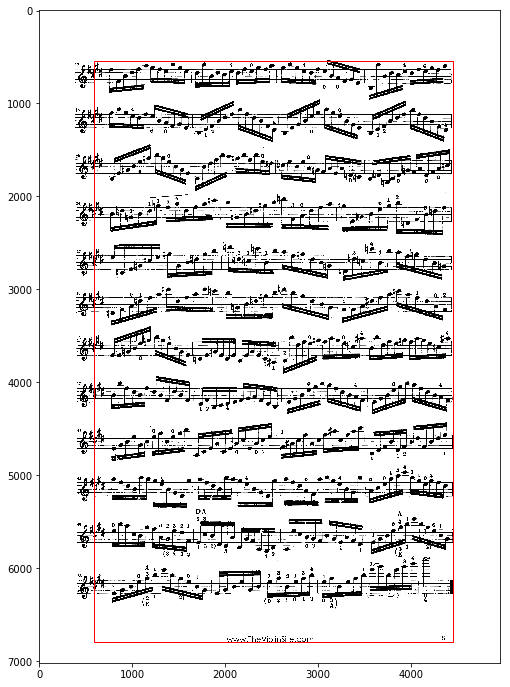

In [25]:
showImageWithBB(Irot, a,b,c)

In [ ]:
I = importImage(pic)
Irot, theta = rotateToHorizontal(I)
Icrop = getCropped(Irot)
bnds = getStripBoundariesNonPiano(Icrop, showPlot=True)
bnds_piano = getStripBoundaries(Icrop, showPlot=True)

/home/dbashir/anaconda2/envs/py36/lib/python3.6/site-packages/ipykernel/__main__.py:2: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0.
Use ``matplotlib.pyplot.imread`` instead.
  from ipykernel import kernelapp as app


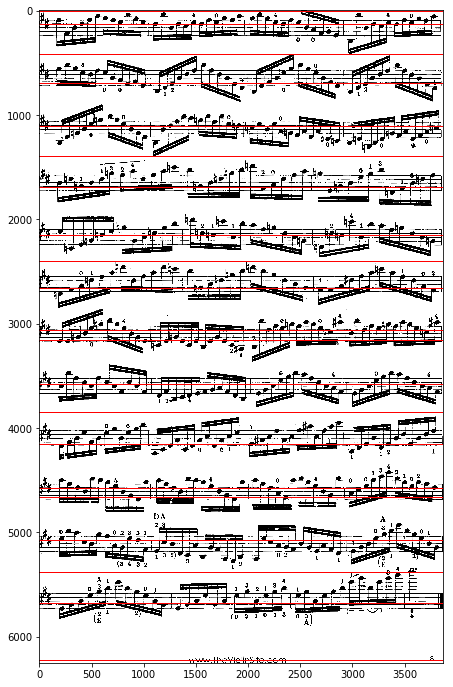

In [45]:
visualizeBoundaries(Icrop, bnds)

In [46]:
bnds

[0,
 132,
 412,
 690,
 1106,
 1398,
 1690,
 2154,
 2398,
 2660,
 3059,
 3152,
 3578,
 3848,
 4155,
 4571,
 4665,
 5072,
 5383,
 5675,
 6224,
 6249]

In [26]:
correct_bnds = [0, 410, 870, 1400, 1900, 2380, 2840, 3360, 3820, 4330, 4840, 5310, 5850]

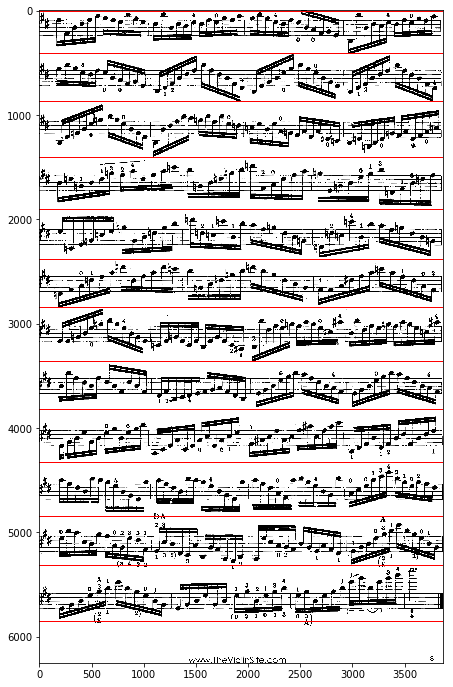

In [82]:
visualizeBoundaries(Icrop, correct_bnds)

In [ ]:
strips = getStrips(Icrop, correct_bnds)
# noice
for s in strips:
    inv_s, boxes, lines = get_lines_bboxes(s)
    visualize_output(s, inv_s, lines, boxes)

In [88]:
# try w 300 dpi
pic = 'etude_8_300dpi.png'

In [43]:
I = importImage(pic)
Irot, theta = rotateToHorizontal(I)
Icrop = getCropped(Irot)
# bnds = getStripBoundariesNonPiano(Icrop)
# bnds_piano = getStripBoundaries(Icrop)

/home/dbashir/anaconda2/envs/py36/lib/python3.6/site-packages/ipykernel/__main__.py:2: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0.
Use ``matplotlib.pyplot.imread`` instead.
  from ipykernel import kernelapp as app
/home/dbashir/anaconda2/envs/py36/lib/python3.6/site-packages/scipy/signal/wavelets.py:364: ComplexWarning: Casting complex values to real discards the imaginary part
  mode='same')


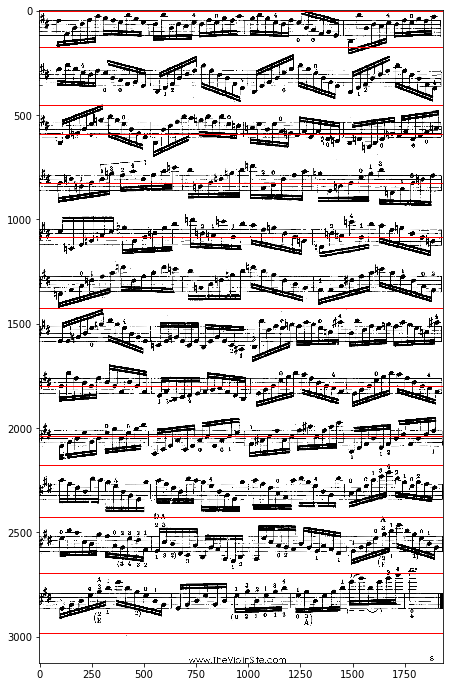

In [90]:
visualizeBoundaries(Icrop, bnds)

In [91]:
bnds

[0, 176, 451, 590, 828, 1086, 1425, 1800, 2037, 2177, 2428, 2693, 2981, 3125]

In [29]:
bnds_old = [int(i/2) for i in correct_bnds]

In [30]:
bnds_old

[0, 205, 435, 700, 950, 1190, 1420, 1680, 1910, 2165, 2420, 2655, 2925]

In [45]:
I = importImage(pic)
Irot, theta = rotateToHorizontal(I)
Icrop = getCropped(Irot)

/home/dbashir/anaconda2/envs/py36/lib/python3.6/site-packages/ipykernel/__main__.py:2: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0.
Use ``matplotlib.pyplot.imread`` instead.
  from ipykernel import kernelapp as app


In [44]:
bnds = [0, 205, 435, 700, 950, 1190, 1420, 1680, 1910, 2165, 2420, 2655, 2925]

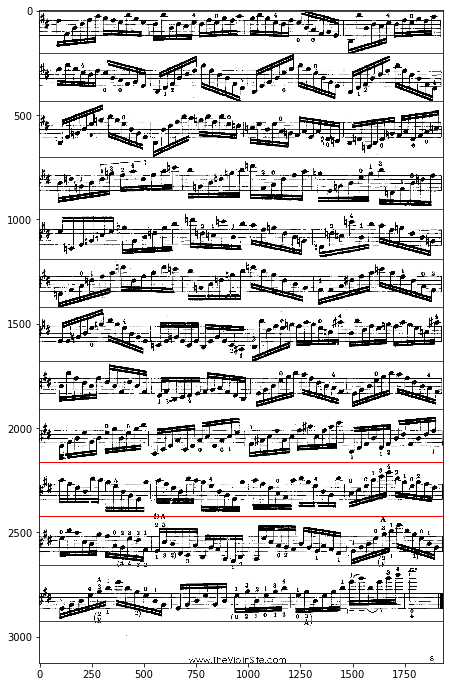

In [46]:
visualizeBoundaries(Icrop, bnds)

In [47]:
strips = getStrips(Icrop, bnds)

In [33]:
strips = getStrips(Icrop, bnds)
lines_list = []
# noice
for s in strips:
    inv_s, boxes, lines = get_lines_bboxes(s)
    lines_list.append(lines)
    visualize_output(s, inv_s, lines, boxes)

NameError: name 'model' is not defined

In [36]:
# we'll pick one example
s = strips[0]
inv_s, boxes, lines = get_lines_bboxes(s)

NameError: name 'model' is not defined

In [48]:
s = strips[0]

In [49]:
lines = [50, 68, 86, 104, 121]

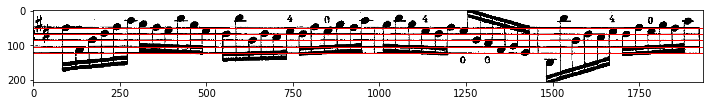

In [50]:
showImage(s)
for line in lines:
    plt.axhline(y=line, color='red', linewidth=1)
plt.show()

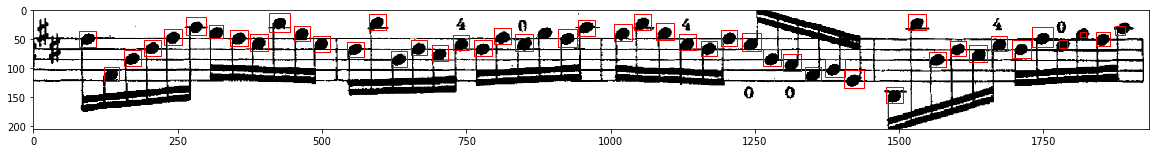

In [54]:
inv_s, boxes, lines = get_lines_bboxes(s)
visualize_bboxes(s, inv_s, boxes)

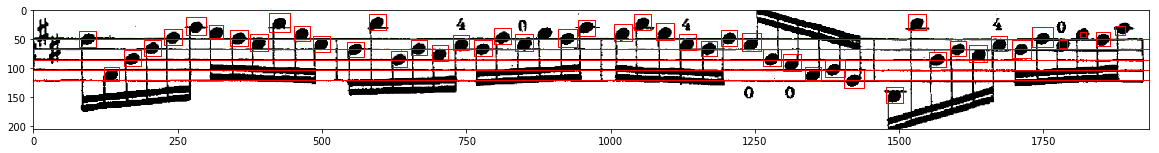

note-location pairs: [(4, 93.5), (-3, 135.0), (0, 171.5), (2, 206.0), (4, 242.5), (7, 281.5), (5, 316.5), (4, 355.5), (3, 390.5), (7, 426.5), (5, 465.0), (3, 499.0), (2, 558.0), (7, 596.0), (0, 633.5), (2, 668.5), (1, 704.0), (3, 741.0), (2, 779.0), (5, 813.0), (3, 850.5), (4, 925.5), (6, 958.0), (5, 1022.0), (7, 1055.5), (5, 1094.5), (3, 1133.0), (2, 1170.5), (4, 1205.0), (3, 1244.5), (0, 1279.5), (-1, 1314.5), (-3, 1351.0), (-2, 1389.0), (-4, 1422.0), (-7, 1492.0), (7, 1531.0), (0, 1566.5), (2, 1602.0), (1, 1637.5), (3, 1673.0), (2, 1712.0), (4, 1748.0), (3, 1784.0), (5, 1818.5), (4, 1853.5), (6, 1883.0)]


In [136]:
visualize_output(s, inv_s, lines, boxes)

In [106]:
note_vals = sorted([-7, -4, -3, -3, -2, -1, 0, 0, 0, 0, 1, 1, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 4, 4, 4, 4, 4, 4, 4, 5, 5, 5, 5, 5, 5, 6, 7, 6, 7, 7, 7, 7])

In [107]:
note_vals

[-7,
 -4,
 -3,
 -3,
 -2,
 -1,
 0,
 0,
 0,
 0,
 1,
 1,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 5,
 5,
 5,
 5,
 5,
 5,
 6,
 6,
 7,
 7,
 7,
 7,
 7]

In [108]:
uq_vals = np.unique(note_vals)

In [109]:
uq_vals

array([-7, -4, -3, -2, -1,  0,  1,  2,  3,  4,  5,  6,  7])

In [127]:
val_chunks = [[x] for x in  uq_vals]

In [128]:
val_chunks

[[-7], [-4], [-3], [-2], [-1], [0], [1], [2], [3], [4], [5], [6], [7]]

In [130]:
binary_vectors = []

In [131]:
for chunk in val_chunks:
    binary_vector = [1 if i in chunk else 0 for i in range(-7,8)]
    binary_vectors.append(binary_vector)

In [132]:
binary_vectors

[[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
 [0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
 [0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0],
 [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0],
 [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0],
 [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0],
 [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1]]

In [116]:
# now we create our binary vector. For now let's just cover two octaves. 
binary_vector = [1 if i in uq_vals else 0 for i in range(-7,8)]

In [117]:
binary_vector

[1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]

Above is a set of vectors that identify the note at each "timestamp" along the line. Since it's violin music each vector just has one bit set to one--piano music etc would be more complicated.

Explanation: We'd have generated vectors like this for all strips. We also would have performed a technique like hashing for the pictures in our dataset--so we'd have looked for the page in the dataset that had the ~most~ matches (probably robust to pages not containing the exact same lines) in terms of vectors, and predicted that as our ground truth image.

So the piece was Kreutzer Etude #8.

In [119]:
ll, w, b = getBoundingBox(Irot, debug=True)

cmeans:  [0. 0. 0. ... 0. 0. 0.]
cmean thresh: 0.0030452357615456923
rmeans: [0. 0. 0. ... 0. 0. 0.]
rmean_thresh: 0.008066994137734259
